## Getting started with Qiskit

Qiskit is a widely employed quantum computing framework, which includes a large software library and extensive documentation, in particular the <a href="https://qiskit.org/textbook">Qiskit tutorial</a>. By default, Qiskit connects to its own simulator module ('AER') or the IBM QEngine backend, for other backends (e.g. IonQ) additional modules must be installed. 

Gates are implemented as methods, e.g. R<sub>x</sub>(&theta;) |<i>state</i>&gt; &nbsp; is implemented as: &nbsp; QuantumCircuit.Rx(theta,qubit) <br>

Use: pip install 'qiskit[visualization]' &nbsp; (or: pip3 install ... on most Linux and MacOS platforms)<br>
pip install qiskit-ionq <br>

API tokens can be set as environment variables or argument when instantiating a 'Provider' class: 

In [ ]:
#on command line: export QISKIT_IONQ_API_TOKEN=“token”
#on python shell: from qiskit_ionq import IonQProvider
#on python shell: provider = IonQProvider()
#or
import os
ionq_token=os.getenv('IONQ_API_TOKEN')
from qiskit_ionq import IonQProvider
provider = IonQProvider(ionq_token)

# show supported backends
print(provider.backends()) 

# create backends for simulator and hardware
backend_sim = provider.get_backend("ionq_simulator")
backend_qpu = provider.get_backend("ionq_qpu")

In [ ]:
#If you have a IBMQ Experience account:
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy

provider0 = IBMQ.load_account()
# We choose the least busy device
backend_ibmq = least_busy(provider0.backends(operational = True, simulator=False, status_msg='active',
                                       filters=lambda x: x.configuration().n_qubits >= n+1)) 
print("We are using...",backend_ibmq)
print("It has",backend_ibmq.status().pending_jobs,"pending jobs")

In [ ]:
# create bankend for Qiskit's AER (QSAM simulator)
from qiskit import Aer
aer_sim = Aer.get_backend('qasm_simulator') 

Circuits are set up by means of the QuantumCircuit class.

### Example: Bell State circuit:

A Bell State is a pair of quantum objects, which are aligned (e.g. spins or qubits):
$$ |A\rangle \otimes |B\rangle = \frac{1}{\sqrt{2}} (|0\rangle \otimes |0\rangle + |1\rangle \otimes |1\rangle )$$
(The symbol $\otimes$ denotes an outer product, which combines the spaces, in which the objects operate, into a higher dimensional space. We often use the short form: $|A\rangle \otimes |B\rangle = |AB\rangle$).

Here, both qubits are either in $!|0\rangle$ or $|1\rangle$ state, in other words: the system is either in a $|00\rangle$ or $|11\rangle$ state, mixed states ($|01\rangle>$ or $|10\rangle$) do not occur.
A Bell State is obviously an example for entanglement: both qubits act coherently.

![bell_state.png](attachment:bell_state.png)

This is realized by initializing one qubit to 50\% probability in $|0\rangle$ and 50\% in $|1\rangle$ state, and then changing the state of the second qubit (initially in $|0\rangle$ state) if the first qubit is in $|1\rangle$.
The first operation is done by a Hadamard gate, the second by a CNOT gate, which flips the state ('NOT') of the target qubit under the condition ('C') that the control qubit is in $|1\rangle$ state.

Note: in Qiskit the circuit contains 2 qubits and 2 classical bits, which contain the measured results. Measurements on quantum objects represent their projections on the base or eigen-states of the measured quantity.

In [ ]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2,2)   # arguments: qubits,classical_bits
qc.h(0)  # hadamard on qubit 0
qc.cx(0,1) # CNOT (also called CX): control is qubit 0, target is qubit 1
qc.measure([0,1],[0,1]) # arguments: list of qubits to measure, list of bits that contain the results

# display the circuit
qc.draw(output='mpl')

Now this circuit can submitted to various backends, e.g. AER simulator, IonQ simulator, and IonQ hardware 

In [ ]:
# run circuit on AER simulator and print results (counts) and their probabilities
job = aer_sim.run(qc, shots=1000).result()  # 2nd argument optional: shots=1024 by default
print("AER Simulator: measured counts",job.get_counts())
print("AER Simulator: measured probabilities", {k:v/1000. for k,v in job.get_counts().items()})

In [ ]:
# run circuit on IonQ simulator
job = backend_sim.run(qc, shots=1000)
print("IonQ simulator: measured counts",job.get_counts())
print("IonQ simulator: measured probabilities",job.get_probabilities())

In [7]:
#run on IonQ hardware:  
qpu_job = backend_qpu.run(qc)  #if you skip 2nd arg, it defaults to 1024

# since the job is queued and may take several minutes to get processed, 
# we check its status every minute until the job is done
from qiskit.providers.jobstatus import JobStatus
import time
while qpu_job.status() is not JobStatus.DONE:
   print("Job status is", qpu_job.status())
   time.sleep(60)
# break out of the loop when the job finished:
print("Job status is",qpu_job.status())


print("IonQ hardware: measured counts",counts)
print("IonQ hardware: measured probabilities",qpu_job.get_probabilities())

IonQCredentialsError: IonQCredentialsError('Credentials `token` may not be None!')

In [ ]:
# plot the results
all_states = ['00','01','10','11']
if len(counts) < 4:
    for j in all_states:
        if j not in counts.keys():
            counts[j]=0
reordered = {k:counts[k] for k in all_states}

from qiskit.visualization import plot_histogram
plot_histogram(reordered)

### Example: Teleportation

The term 'teleportation' refers to transferring a quantum state |&psi;&gt; without moving the quantum object itself. This is accomplished by entangling a shared Bell-state qubit pair with the qubit to be transferred.

Suppose Alice and Bob share a Bell-state pair <i>qA-qB</i>, and Alice wants to send Bob the quantum state of a payload qubit <i>qP</i>: she entangles <i>qP</i> with her part, <i>qA</i>, of the Bell pair, then measures both qubits and sends Bob the result of the measurement (2 conventional bits) over the internet. Bob uses these 2 conventional bits to manipulate his part, <i>qB</i>, of the Bell pair such that it contains the quantum state of the payload qubit <i>qP</i>.

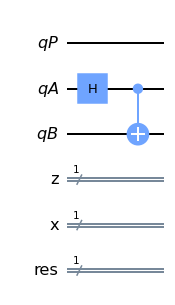

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

qP,qA,qB = QuantumRegister(1, name="qP"), QuantumRegister(1, name="qA"), QuantumRegister(1, name="qB")
xbit,zbit,res = ClassicalRegister(1, name="x"), ClassicalRegister(1, name="z"), ClassicalRegister(1,name="res")
qcteleport = QuantumCircuit(qP,qA,qB,zbit,xbit,res)

# create Bell pair
qcteleport.h(qA)
qcteleport.cx(qA,qB)
qcteleport.draw(output="mpl")

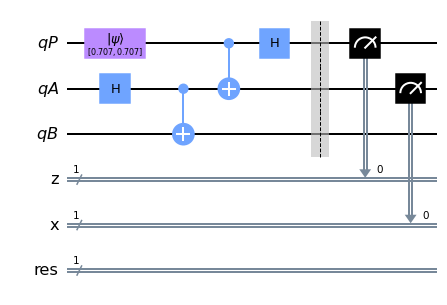

In [2]:
from math import sqrt,pi
from qiskit.quantum_info import random_statevector
from qiskit.extensions import Initialize
from qiskit.visualization import array_to_latex, plot_bloch_multivector

# prepare payload qubit
qcteleport.initialize([1/sqrt(2),1/sqrt(2)],0)

# entangle Alice's Bell state with payload qubit
qcteleport.cx(qP,qA)
qcteleport.h(qP)

# measure qP and qA
qcteleport.barrier()
qcteleport.measure(qP,zbit)
qcteleport.measure(qA,xbit)
qcteleport.draw(output='mpl')

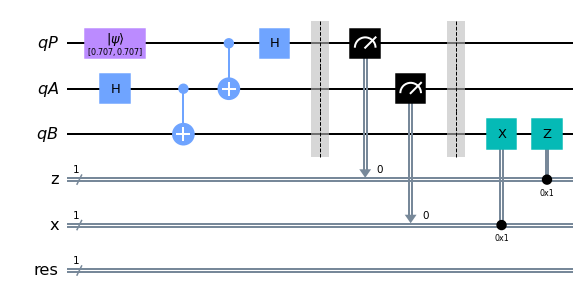

In [3]:
# Bob applies X gate if x=1 and Z gate if z=1
qcteleport.barrier()
qcteleport.x(qB).c_if(xbit,1)
qcteleport.z(qB).c_if(zbit,1)
qcteleport.draw(output='mpl')

In [6]:
qcteleport.barrier()
#uncompute payload preparation
qcteleport.h(qB)
qcteleport.measure(qB,res)

job = aer_sim.run(qcteleport, shots=100).result()
display('rotated by {} yields {}'.format(angle,job.get_counts()))

NameError: ignored